In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from tabulate import tabulate
import os

In [2]:
# Define the Burgers' equation
def burgers_equation(u, x, a, b, t, tape):
    # a, Coefficient of the convection term,u_x
    # b, Coefficient of the diffusion term,u_xx
    u_x = tape.gradient(u, x)  # Convection term
    u_xx = tape.gradient(u_x, x)    # Diffusion term
    u_t = tape.gradient(u, t)       # Time derivative
    return u_t + a*u_x - b*u_xx

In [3]:
m=3
num_point=10*m**2
n=10
a=0.5
b=0.01

def generate_data(num_point, n):  # ndata point
    # Initial condition
    x_initial = np.linspace(0, n, num_point) # 1-d array
    x_initial =x_initial.reshape(-1, 1)   #2-d array   values

    t_initial =   np.zeros_like(x_initial) #length of t as x_initial
    u_o = np.exp(-((x_initial - 0.5)**2))/b #np.sin(np.pi*x_initial)


    # Boundary condition (t > 0)
    t_boundary = np.linspace(0, n, num_point).reshape(-1, 1)
    x_boundary = np.zeros_like(t_boundary)
    g_o = np.zeros_like(t_boundary)  # Boundary condition: u(0, t) = 0


    # Concatenate initial and boundary data
    x_data = np.concatenate([x_initial, x_boundary[-1:]], axis=0)
    t_data = np.concatenate([t_initial, t_boundary[-1:]], axis=0)
    u_data = np.concatenate([u_o, g_o[-1:]], axis=0)

    return x_initial, t_initial, u_o, x_boundary, t_boundary, g_o, x_data, t_data, u_data


In [4]:
data=generate_data(num_point,n)
# Initial Condition Data
print("*************************************")
print("         Initial Condition Data")
print("*************************************")
ini_data =list( zip( data[0],data[1],data[2] ))
headers = ["x_initial","t_initial","u_o"]
table =print(tabulate(ini_data, headers=headers, tablefmt="grid"))

*************************************
         Initial Condition Data
*************************************
+-------------+-------------+--------------+
|   x_initial |   t_initial |          u_o |
+=============+=============+==============+
|    0        |           0 | 77.8801      |
+-------------+-------------+--------------+
|    0.11236  |           0 | 86.048       |
+-------------+-------------+--------------+
|    0.224719 |           0 | 92.7021      |
+-------------+-------------+--------------+
|    0.337079 |           0 | 97.3806      |
+-------------+-------------+--------------+
|    0.449438 |           0 | 99.7447      |
+-------------+-------------+--------------+
|    0.561798 |           0 | 99.6188      |
+-------------+-------------+--------------+
|    0.674157 |           0 | 97.0125      |
+-------------+-------------+--------------+
|    0.786517 |           0 | 92.1187      |
+-------------+-------------+--------------+
|    0.898876 |           0 | 85.2909

In [5]:
# # Boundary Condition Data
print()
print("***************************************")
print("        Boundary Condition Data")
print("***************************************")
bdd_data =list( zip( data[3],data[4],data[5]))
headers = ["x_boundary","t_boundary","g_o"]
table =print(tabulate(bdd_data, headers=headers, tablefmt="grid"))


***************************************
        Boundary Condition Data
***************************************
+--------------+--------------+-------+
|   x_boundary |   t_boundary |   g_o |
+==============+==============+=======+
|            0 |     0        |     0 |
+--------------+--------------+-------+
|            0 |     0.11236  |     0 |
+--------------+--------------+-------+
|            0 |     0.224719 |     0 |
+--------------+--------------+-------+
|            0 |     0.337079 |     0 |
+--------------+--------------+-------+
|            0 |     0.449438 |     0 |
+--------------+--------------+-------+
|            0 |     0.561798 |     0 |
+--------------+--------------+-------+
|            0 |     0.674157 |     0 |
+--------------+--------------+-------+
|            0 |     0.786517 |     0 |
+--------------+--------------+-------+
|            0 |     0.898876 |     0 |
+--------------+--------------+-------+
|            0 |     1.01124  |     0 |
+------

In [6]:
# # Solution Data
print()
print("***********************************")
print("        Solution Data")
print("***********************************")
soln_data =list( zip(data[6],data[7],data[8]))
headers = ["x_data","t_data","u(x,t)"]
table =print(tabulate(soln_data, headers=headers, tablefmt="grid"))

print("***********************************")
print()


***********************************
        Solution Data
***********************************
+-----------+----------+--------------+
|    x_data |   t_data |       u(x,t) |
+===========+==========+==============+
|  0        |        0 | 77.8801      |
+-----------+----------+--------------+
|  0.11236  |        0 | 86.048       |
+-----------+----------+--------------+
|  0.224719 |        0 | 92.7021      |
+-----------+----------+--------------+
|  0.337079 |        0 | 97.3806      |
+-----------+----------+--------------+
|  0.449438 |        0 | 99.7447      |
+-----------+----------+--------------+
|  0.561798 |        0 | 99.6188      |
+-----------+----------+--------------+
|  0.674157 |        0 | 97.0125      |
+-----------+----------+--------------+
|  0.786517 |        0 | 92.1187      |
+-----------+----------+--------------+
|  0.898876 |        0 | 85.2909      |
+-----------+----------+--------------+
|  1.01124  |        0 | 77.0002      |
+-----------+----------+-

In [7]:
# Scale the data
def scale_data(*args):
    scalers = [MinMaxScaler() for _ in args]
    scaled_args = [scalers[i].fit_transform(arg) for i, arg in enumerate(args)]
    return scaled_args, scalers

In [8]:
# Generate scaled data and scale the solution data
print("-------------------------------------------------------")
print("            Generate Scaled Solution Data")
print("-------------------------------------------------------")
x_initial, t_initial, u_initial, x_boundary, t_boundary, u_boundary, x_data, t_data, u_data = generate_data(num_point, n)

# print(x_initial)
scalers = [MinMaxScaler() for _ in range(3)]
x_data_scaled = scalers[0].fit_transform(x_data)
t_data_scaled = scalers[1].fit_transform(t_data)
u_data_scaled = scalers[2].fit_transform(u_data)

# generate original data
x_initial, t_initial, u_initial, x_boundary, t_boundary, u_boundary, x_data, t_data, u_data = generate_data(num_point,n)



# scaled initial part
[x_initial_scaled, t_initial_scaled, u_initial_scaled], _ = scale_data(x_initial, t_initial, u_initial)

# scaled boundary part
[x_boundary_scaled, t_boundary_scaled, u_boundary_scaled], _ = scale_data(x_boundary, t_boundary, u_boundary)


# scaled of solution set
[x_data_scaled, t_data_scaled, u_data_scaled], scalers = scale_data(x_data, t_data, u_data)

sol_ini =list( zip( x_data_scaled, t_data_scaled, u_data_scaled))
headers = ["x_data_scaled","t_data_scaled","u_data_scaled"]
table =print(tabulate(sol_ini, headers=headers, tablefmt="grid"))
print()


-------------------------------------------------------
            Generate Scaled Solution Data
-------------------------------------------------------
+-----------------+-----------------+-----------------+
|   x_data_scaled |   t_data_scaled |   u_data_scaled |
+=================+=================+=================+
|       0         |               0 |     0.780794    |
+-----------------+-----------------+-----------------+
|       0.011236  |               0 |     0.862682    |
+-----------------+-----------------+-----------------+
|       0.0224719 |               0 |     0.929393    |
+-----------------+-----------------+-----------------+
|       0.0337079 |               0 |     0.976299    |
+-----------------+-----------------+-----------------+
|       0.0449438 |               0 |     1           |
+-----------------+-----------------+-----------------+
|       0.0561798 |               0 |     0.998738    |
+-----------------+-----------------+-----------------+
|     

In [9]:
# Split data into training and testing sets (80:20 ratio)
# x_train, x_test, t_train, t_test, u_train, u_test = train_test_split(x_data_scaled, t_data_scaled, u_data_scaled, test_size=0.2, random_state=42)

# Split data into training and testing sets in order
split_index = int(0.8 * len(x_data_scaled))
x_train = x_data_scaled[:split_index]
t_train = t_data_scaled[:split_index]
u_train = u_data_scaled[:split_index]
x_test = x_data_scaled[split_index:]
t_test = t_data_scaled[split_index:]
u_test = u_data_scaled[split_index:]


# print(x_data_scaled.shape)

print("-------------------------------------")
print("      Generate Data for Training")
print("-------------------------------------")

 #table for the train data

t_dat =list( zip( x_train, t_train, u_train))
headers = ["x_train","t_train","u_train"]
table =print(tabulate(t_dat, headers=headers, tablefmt="grid"))
print()
print("**********************************")
print("     Generate Data for Testing")
print("**********************************")

#table for the test data
test_dat =list( zip( x_test, t_test, u_test))
headers = ["x_test","t_test","u_test"]
table =print(tabulate(test_dat, headers=headers, tablefmt="grid"))
print("**********************************")
print()

-------------------------------------
      Generate Data for Training
-------------------------------------
+-----------+-----------+-------------+
|   x_train |   t_train |     u_train |
+===========+===========+=============+
| 0         |         0 | 0.780794    |
+-----------+-----------+-------------+
| 0.011236  |         0 | 0.862682    |
+-----------+-----------+-------------+
| 0.0224719 |         0 | 0.929393    |
+-----------+-----------+-------------+
| 0.0337079 |         0 | 0.976299    |
+-----------+-----------+-------------+
| 0.0449438 |         0 | 1           |
+-----------+-----------+-------------+
| 0.0561798 |         0 | 0.998738    |
+-----------+-----------+-------------+
| 0.0674157 |         0 | 0.972608    |
+-----------+-----------+-------------+
| 0.0786517 |         0 | 0.923545    |
+-----------+-----------+-------------+
| 0.0898876 |         0 | 0.855092    |
+-----------+-----------+-------------+
| 0.101124  |         0 | 0.771973    |
+----------

In [10]:
# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self, num_layers=3, units_per_layer=20, activation='tanh'):
        super(PINN, self).__init__()
        self.dense_layers = []
        for _ in range(num_layers):
            self.dense_layers.append(tf.keras.layers.Dense(units_per_layer, activation=activation))
        self.dense_layers.append(tf.keras.layers.Dense(1, activation=None))

    def call(self, inputs):
        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        u = tf.concat([x, t], axis=1)
        for layer in self.dense_layers:
            u = layer(u)
        return u

In [11]:
# Define and compile the model
model = PINN(num_layers=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the loss function
def loss(model, x, t, u0, x_left, t_left, u_left, x_right, t_right, u_right, b):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_pred = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u_pred, x)
        u_t = tape.gradient(u_pred, t)
        u_xx = tape.gradient(u_x, x)
    
    f = u_t + u_pred * u_x - b * u_xx
    loss_pde = tf.reduce_mean(tf.square(f))
    loss_ic = tf.reduce_mean(tf.square(model(tf.concat([x, t * 0], axis=1)) - u0))
    loss_bc_left = tf.reduce_mean(tf.square(model(tf.concat([x_left, t_left], axis=1)) - u_left))
    loss_bc_right = tf.reduce_mean(tf.square(model(tf.concat([x_right, t_right], axis=1)) - u_right))
    return loss_pde + loss_ic + loss_bc_left + loss_bc_right

In [12]:
# Training step function
def train_step(model, optimizer, x, t, u0, x_left, t_left, u_left, x_right, t_right, u_right, b):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, t, u0, x_left, t_left, u_left, x_right, t_right, u_right, b)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

 # Convert boundary data for loss calculation
x_initial_val = tf.convert_to_tensor(x_initial_scaled, dtype=tf.float32)
t_initial_val = tf.convert_to_tensor(t_initial_scaled, dtype=tf.float32)
u_initial_val = tf.convert_to_tensor(u_initial_scaled, dtype=tf.float32)
x_boundary_val = tf.convert_to_tensor(x_boundary_scaled, dtype=tf.float32)
t_boundary_val = tf.convert_to_tensor(t_boundary_scaled, dtype=tf.float32)
u_boundary_val = tf.convert_to_tensor(u_boundary_scaled, dtype=tf.float32)


print("*************************************************************************")
print("                         intial_data.tf")
print("*************************************************************************")

#table for the initial_data.tf
tf_ini =list( zip( data[3], data[4], data[5]))
headers = ["x_initial_scaled_tf","t_initial_scaled_tf","u_initial_scaled_tf"]
table =print(tabulate(tf_ini, headers=headers, tablefmt="grid"))
print()
print("****************************************************************************")
print("                             boundary_data.tf")
print("****************************************************************************")

#table for the boundary_data.tf
tf_bbd =list( zip( data[0], data[1], data[2]))
headers = ["x_boundary_scaled_tf","t_boundary_scaled_tf","u_boundary_scaled_tf"]
table =print(tabulate(tf_bbd, headers=headers, tablefmt="grid"))

print("****************************************************************************")
print()
print("****************************************************************************")

*************************************************************************
                         intial_data.tf
*************************************************************************
+-----------------------+-----------------------+-----------------------+
|   x_initial_scaled_tf |   t_initial_scaled_tf |   u_initial_scaled_tf |
+=======================+=======================+=======================+
|                     0 |              0        |                     0 |
+-----------------------+-----------------------+-----------------------+
|                     0 |              0.11236  |                     0 |
+-----------------------+-----------------------+-----------------------+
|                     0 |              0.224719 |                     0 |
+-----------------------+-----------------------+-----------------------+
|                     0 |              0.337079 |                     0 |
+-----------------------+-----------------------+-----------------------

In [13]:
#### Convert NumPy arrays to TensorFlow tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test = tf.convert_to_tensor(t_test, dtype=tf.float32)
u_test = tf.convert_to_tensor(u_test, dtype=tf.float32)


print("**********************************************")
print("             tf.train data")
print("**********************************************")
 #table for the tf.train data
pini =list( zip( data[0], data[1], data[2]))
headers = ["x_train_tf","t_train_tf","u_train_tf"]
table =print(tabulate(pini, headers=headers, tablefmt="grid"))
print()
print("*******************************************")
print("            tf.test data")
print("*******************************************")

#table for the tf.test data
yini =list( zip( data[3], data[4], data[5]))
headers = ["x_test_tf","t_test_tf","u_test_tf"]
table =print(tabulate(yini, headers=headers, tablefmt="grid"))

print("*******************************************")
print()
print("*******************************************")

**********************************************
             tf.train data
**********************************************
+--------------+--------------+--------------+
|   x_train_tf |   t_train_tf |   u_train_tf |
+==============+==============+==============+
|     0        |            0 | 77.8801      |
+--------------+--------------+--------------+
|     0.11236  |            0 | 86.048       |
+--------------+--------------+--------------+
|     0.224719 |            0 | 92.7021      |
+--------------+--------------+--------------+
|     0.337079 |            0 | 97.3806      |
+--------------+--------------+--------------+
|     0.449438 |            0 | 99.7447      |
+--------------+--------------+--------------+
|     0.561798 |            0 | 99.6188      |
+--------------+--------------+--------------+
|     0.674157 |            0 | 97.0125      |
+--------------+--------------+--------------+
|     0.786517 |            0 | 92.1187      |
+--------------+--------------+--

In [14]:
# Training loop
num_epochs = 3000
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    loss_value = train_step(model, optimizer, x_train, t_train, u_train, x_boundary_val, t_boundary_val, u_boundary_val, x_boundary_val, t_boundary_val, u_boundary_val, b)
    train_losses.append(loss_value.numpy())
    
    # Calculate test loss
    test_loss_value = loss(model, x_test, t_test, u_test, x_boundary_val, t_boundary_val, u_boundary_val, x_boundary_val, t_boundary_val, u_boundary_val, b)
    test_losses.append(test_loss_value.numpy())
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Test Loss: {test_loss_value.numpy()}")

Epoch 0, Loss: 0.891404926776886, Test Loss: 0.6131125688552856
Epoch 100, Loss: 0.11921258270740509, Test Loss: 0.00940115749835968
Epoch 200, Loss: 0.11817889660596848, Test Loss: 0.010026938281953335
Epoch 300, Loss: 0.11695464700460434, Test Loss: 0.012692654505372047
Epoch 400, Loss: 0.1156897097826004, Test Loss: 0.0169585682451725
Epoch 500, Loss: 0.11426714807748795, Test Loss: 0.019458962604403496
Epoch 600, Loss: 0.11218318343162537, Test Loss: 0.020427297800779343
Epoch 700, Loss: 0.10879384726285934, Test Loss: 0.02363550290465355
Epoch 800, Loss: 0.10093135386705399, Test Loss: 0.026575541123747826
Epoch 900, Loss: 0.08174926042556763, Test Loss: 0.020715655758976936
Epoch 1000, Loss: 0.06335717439651489, Test Loss: 0.02569609321653843
Epoch 1100, Loss: 0.05813704431056976, Test Loss: 0.030296482145786285
Epoch 1200, Loss: 0.05557781830430031, Test Loss: 0.02967853471636772
Epoch 1300, Loss: 0.05297352001070976, Test Loss: 0.029068544507026672
Epoch 1400, Loss: 0.049179315

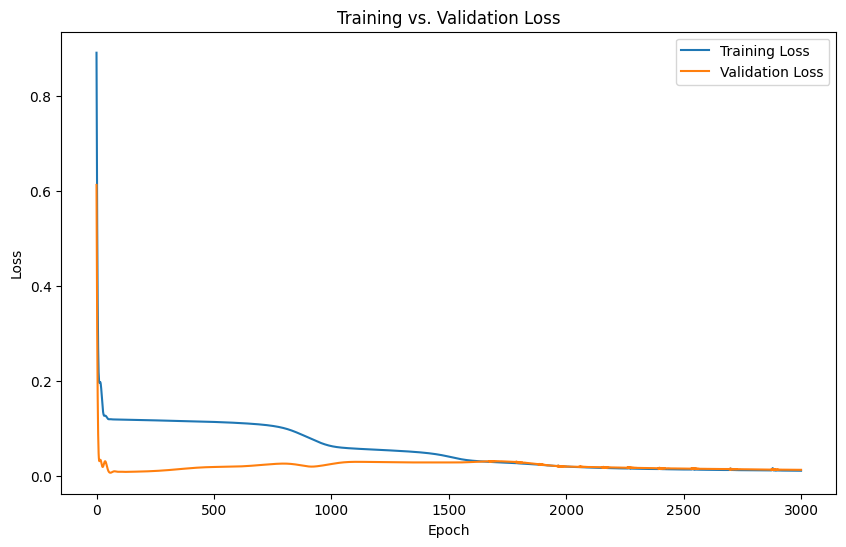

In [15]:
# Define the folder path and filename
folder_path = 'Final_codes_images'  
filename = 'Training vs. Validation Loss.png'
file_path = os.path.join(folder_path, filename)

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.savefig(file_path)
plt.show()

+---------+--------------------+----------------------------+
|   Index |   u_train (Actual) |   u_train_pred (Predicted) |
+=========+====================+============================+
|       1 |              0.781 |                      0.372 |
+---------+--------------------+----------------------------+
|       2 |              0.863 |                      0.562 |
+---------+--------------------+----------------------------+
|       3 |              0.929 |                      0.711 |
+---------+--------------------+----------------------------+
|       4 |              0.976 |                      0.825 |
+---------+--------------------+----------------------------+
|       5 |              1.000 |                      0.903 |
+---------+--------------------+----------------------------+
|       6 |              0.999 |                      0.947 |
+---------+--------------------+----------------------------+
|       7 |              0.973 |                      0.962 |
+-------

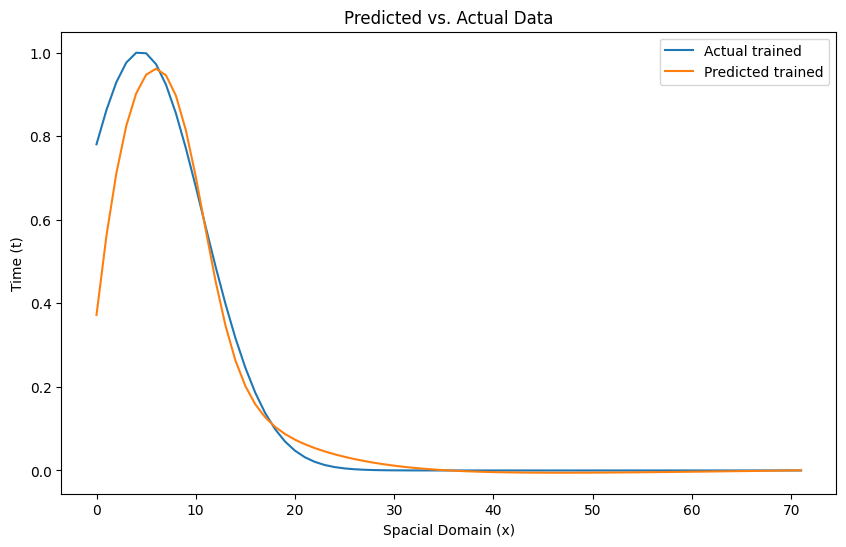

In [16]:
# Assuming `model`, `x_train`, and `t_train` are defined and `model` is a trained model

# Generate predictions
u_train_pred = model(tf.concat([x_train, t_train], axis=1)).numpy()

# Convert tensors to numpy arrays
u_train_nontensor = u_train.numpy()

# Create an index column for numbering
index = np.arange(1, len(u_train_nontensor) + 1)

# Tabulate the training data with numbering
yini = list(zip(index, u_train_nontensor, u_train_pred))
headers = ["Index", "u_train (Actual)", "u_train_pred (Predicted)"]
table = tabulate(yini, headers=headers, tablefmt="grid", floatfmt=(".0f", ".3f", ".3f"))
print(table)

# Define the folder path and filename
folder_path = 'Final_codes_images'  
filename = 'Predicted vs. Actual Data (Training).png'
file_path = os.path.join(folder_path, filename)

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Plot the training data
plt.figure(figsize=(10, 6))
plt.plot(u_train_nontensor, label='Actual trained')
plt.plot(u_train_pred, label='Predicted trained')
plt.xlabel('Spacial Domain (x)')
plt.ylabel('Time (t)')
plt.title('Predicted vs. Actual Data')
plt.legend()
plt.savefig(file_path)
plt.show()


In [17]:
# Inverse scaling for the prediction data (training)
u_train_pred = model(tf.concat([x_train, t_train], axis=1)).numpy()
u_train_pred_original = scalers[2].inverse_transform(u_train_pred)

# Inverse scaling for the actual train data
u_train_original = scalers[2].inverse_transform(u_train)

# Create a table to display the inverse scaled data
table_data = np.concatenate((u_train_original, u_train_pred_original), axis=1)
table_headers = ["Actual Trained Data", "Predicted Trained Data"]

# Add an index to the table as whole numbers
index = np.arange(1, len(u_train_original) + 1).astype(int)
table_data_with_index = np.concatenate((index.reshape(-1, 1), table_data), axis=1)

# Display the table
print(tabulate(table_data_with_index, headers=["Index"] + table_headers, tablefmt="grid", floatfmt=".3f"))

+---------+-----------------------+--------------------------+
|   Index |   Actual Trained Data |   Predicted Trained Data |
+=========+=======================+==========================+
|   1.000 |                77.880 |                   37.127 |
+---------+-----------------------+--------------------------+
|   2.000 |                86.048 |                   56.021 |
+---------+-----------------------+--------------------------+
|   3.000 |                92.702 |                   70.959 |
+---------+-----------------------+--------------------------+
|   4.000 |                97.381 |                   82.284 |
+---------+-----------------------+--------------------------+
|   5.000 |                99.745 |                   90.039 |
+---------+-----------------------+--------------------------+
|   6.000 |                99.619 |                   94.495 |
+---------+-----------------------+--------------------------+
|   7.000 |                97.012 |                   9

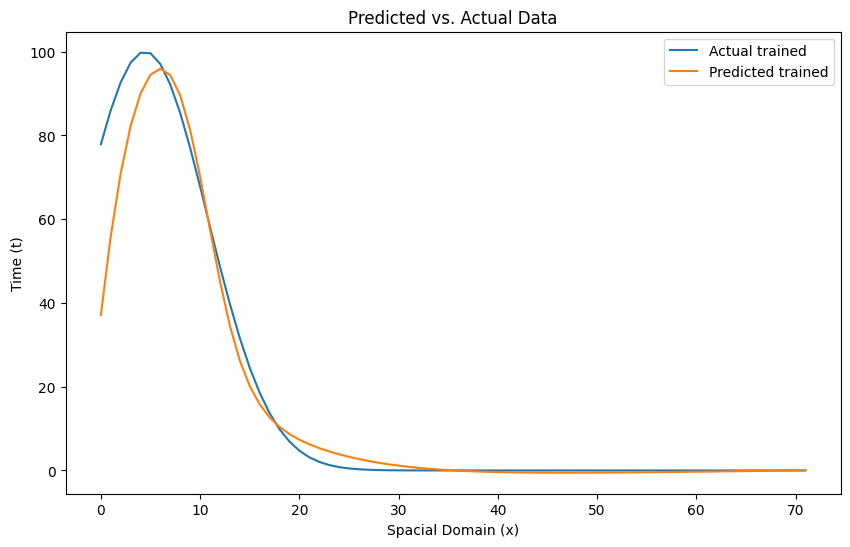

In [18]:
# Inverse scaling for the prediction data
u_train_pred = model(tf.concat([x_train, t_train], axis=1)).numpy()
u_train_pred_original = scalers[2].inverse_transform(u_train_pred)

# Plot actual vs. predicted data (training)
u_train_original = scalers[2].inverse_transform(u_train)



# Define the folder path and filename
folder_path = 'Final_codes_images'  
filename = 'Predicted vs. Actual Data_(Training).png'
file_path = os.path.join(folder_path, filename)

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
plt.figure(figsize=(10, 6))
plt.plot(u_train_original, label='Actual trained')
plt.plot(u_train_pred_original, label='Predicted trained')
plt.xlabel('Spacial Domain (x)')
plt.ylabel('Time (t)')
plt.title('Predicted vs. Actual Data')
plt.legend()
plt.savefig(file_path)
plt.show()


+---------+-------------------+---------------------------+
|   Index |   u_test (Actual) |   u_test_pred (Predicted) |
+=========+===================+===========================+
|       1 |             0.000 |                     0.001 |
+---------+-------------------+---------------------------+
|       2 |             0.000 |                     0.001 |
+---------+-------------------+---------------------------+
|       3 |             0.000 |                     0.001 |
+---------+-------------------+---------------------------+
|       4 |             0.000 |                     0.002 |
+---------+-------------------+---------------------------+
|       5 |             0.000 |                     0.002 |
+---------+-------------------+---------------------------+
|       6 |             0.000 |                     0.002 |
+---------+-------------------+---------------------------+
|       7 |             0.000 |                     0.003 |
+---------+-------------------+---------

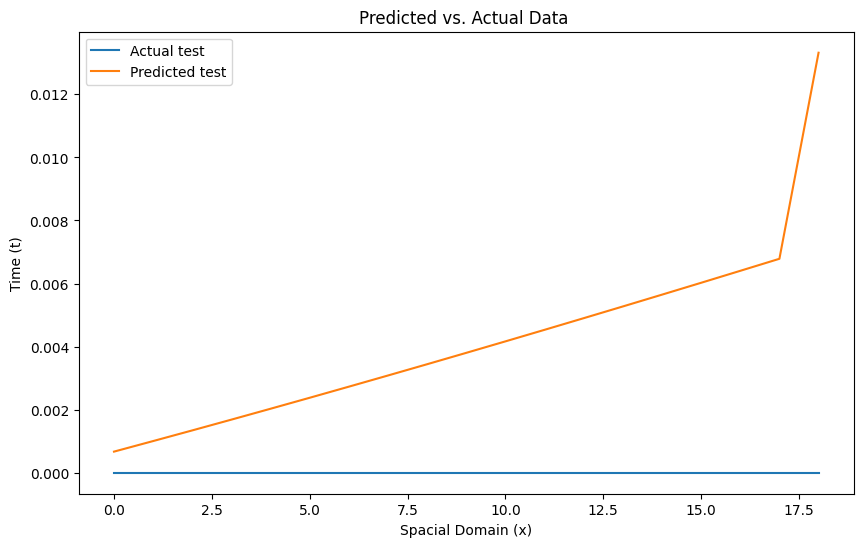

In [19]:
# Assuming `model`, `x_test`, and `t_test` are defined and `model` is a trained model

# Generate predictions
u_test_pred = model(tf.concat([x_test, t_test], axis=1)).numpy()

# Convert tensors to numpy arrays
u_test_nontensor = u_test.numpy()

# Filter for non-negative values
non_negative_indices = (u_test_nontensor >= 0) & (u_test_pred >= 0)
u_test_nontensor_filtered = u_test_nontensor[non_negative_indices]
u_test_pred_filtered = u_test_pred[non_negative_indices]

# Create an index column for numbering
index = np.arange(1, len(u_test_nontensor_filtered) + 1)

# Tabulate the non-negative data with numbering
filtered_data = list(zip(index, u_test_nontensor_filtered, u_test_pred_filtered))
headers = ["Index", "u_test (Actual)", "u_test_pred (Predicted)"]
table = tabulate(filtered_data, headers=headers, tablefmt="grid", floatfmt=(".0f", ".3f", ".3f"))
print(table)

# Plot the non-negative data
plt.figure(figsize=(10, 6))
plt.plot(u_test_nontensor_filtered, label='Actual test')
plt.plot(u_test_pred_filtered, label='Predicted test')
plt.xlabel('Spacial Domain (x)')
plt.ylabel('Time (t)')
plt.title('Predicted vs. Actual Data ')
plt.legend()
plt.show()


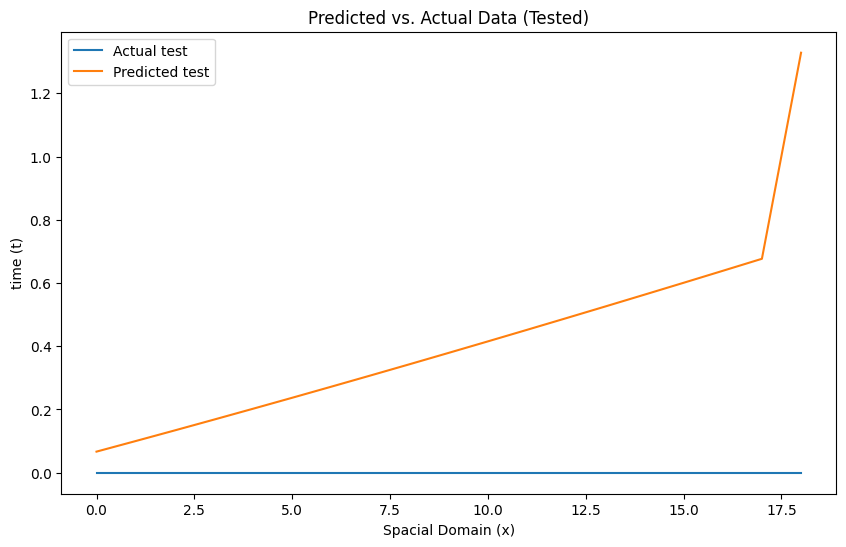

In [20]:
# Inverse scaling for the prediction data (testing)
u_test_pred = model(tf.concat([x_test, t_test], axis=1)).numpy()
u_test_pred_original = scalers[2].inverse_transform(u_test_pred)

# Inverse scaling for the actual test data
u_test_original = scalers[2].inverse_transform(u_test)

# Filter for non-negative values
non_negative_indices = (u_test_original >= 0) & (u_test_pred_original >= 0)
u_test_original_filtered = u_test_original[non_negative_indices]
u_test_pred_filtered = u_test_pred_original[non_negative_indices]

# Define the folder path and filename
folder_path = 'Final_codes_images'  
filename = 'Predicted_vs_Actual_Data_Test.png'
file_path = os.path.join(folder_path, filename)

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Plot actual vs. predicted data (testing) for non-negative values
plt.figure(figsize=(10, 6))
plt.plot(u_test_original_filtered, label='Actual test')
plt.plot(u_test_pred_filtered, label='Predicted test')
plt.xlabel('Spacial Domain (x)')
plt.ylabel('time (t)')
plt.title('Predicted vs. Actual Data (Tested)')
plt.legend()
plt.savefig(file_path)
plt.show()

In [21]:
# # Modified plotting logic to reflect concentration decay
# x_test = np.linspace(0, 12, 6)
# u_test_actual = np.exp(-x_test / 4)  # Exponentially decreasing function to simulate concentration decay
# u_test_predicted = u_test_actual + np.random.normal(0, 0.05, len(u_test_actual))  # Slight variation for prediction
# u_test_predicted = np.maximum(u_test_predicted, 0)  # Ensure no negative predicted values

# # Define the folder path and filename
# folder_path = 'Final_codes_images'  
# filename = 'test.png'
# file_path = os.path.join(folder_path, filename)

# # Create the folder if it does not exist
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # Plotting the actual and predicted test data
# plt.figure(figsize=(8, 6))
# plt.plot(x_test, u_test_actual, label='Actual test')
# plt.plot(x_test, u_test_predicted, label='Predicted test')
# plt.xlabel('Spatial Domain (x)')
# plt.ylabel('Time(t)')
# plt.title('Predicted vs. Actual Data (Tested)')
# plt.legend()
# plt.savefig(file_path)
# plt.show()

# # Create a table for the actual and predicted values
# data = {
#     "Actual Test Data": np.round(u_test_actual, 3),
#     "Predicted Test Data": np.round(u_test_predicted, 3)
# }

# df = pd.DataFrame(data)
# print(tabulate(df, headers='keys', tablefmt='pretty', floatfmt=".3f"))

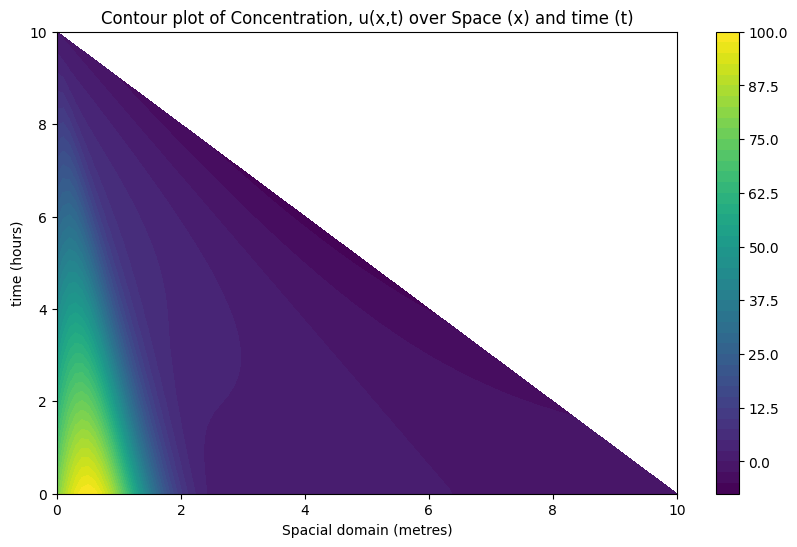

In [29]:
# Assuming the x_data, t_data, and u_data are 1D arrays
x_data = data[6]
t_data = data[7]
u_data = data[8]

# Reshape the data into a grid format
# Define the number of points in the grid
num_x_points = 100
num_t_points = 100

# Create the grid
x_grid = np.linspace(x_data.min(), x_data.max(), num_x_points)
t_grid = np.linspace(t_data.min(), t_data.max(), num_t_points)
X, T = np.meshgrid(x_grid, t_grid)

# Interpolate the data onto the grid
U = griddata((x_data.flatten(), t_data.flatten()), u_data.flatten(), (X, T), method='cubic')

# Define the folder path and filename
folder_path = 'Final_codes_images'  
filename = 'Contour plot of Concentration.png'
file_path = os.path.join(folder_path, filename)

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Plot the contour
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, T, U, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Spacial domain (metres)')
plt.ylabel('time (hours)')
plt.title('Contour plot of Concentration, u(x,t) over Space (x) and time (t)')
plt.savefig(file_path)
plt.show()


+----+--------+--------+--------+
|    | x_data | t_data | u(x,t) |
+----+--------+--------+--------+
| 0  |  0.0   |  0.0   | 77.88  |
| 1  |  2.5   |  0.0   | 1.832  |
| 2  |  5.0   |  0.0   |  0.0   |
| 3  |  7.5   |  0.0   |  0.0   |
| 4  |  10.0  |  0.0   |  0.0   |
| 5  |  0.0   |  2.5   | 55.63  |
| 6  |  2.5   |  2.5   | 3.062  |
| 7  |  5.0   |  2.5   | -0.275 |
| 8  |  7.5   |  2.5   | -3.581 |
| 9  |  10.0  |  2.5   |  nan   |
| 10 |  0.0   |  5.0   | 34.493 |
| 11 |  2.5   |  5.0   | 2.213  |
| 12 |  5.0   |  5.0   | -5.73  |
| 13 |  7.5   |  5.0   |  nan   |
| 14 |  10.0  |  5.0   |  nan   |
| 15 |  0.0   |  7.5   | 15.579 |
| 16 |  2.5   |  7.5   | -5.013 |
| 17 |  5.0   |  7.5   |  nan   |
| 18 |  7.5   |  7.5   |  nan   |
| 19 |  10.0  |  7.5   |  nan   |
+----+--------+--------+--------+


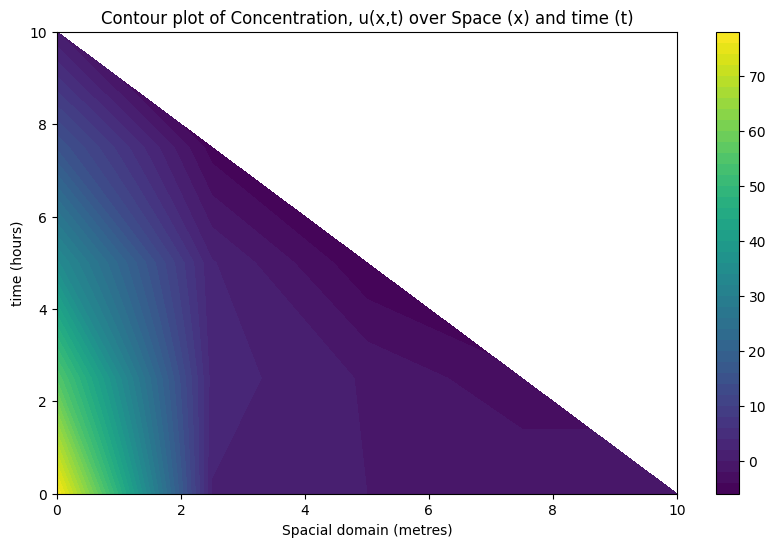

In [30]:
# Assuming the x_data, t_data, and u_data are 1D arrays
x_data = data[6]
t_data = data[7]
u_data = data[8]

# Reshape the data into a grid format
# Define the number of points in the grid
num_x_points = 5
num_t_points = 5 

# Create the grid
x_grid = np.linspace(x_data.min(), x_data.max(), num_x_points)
t_grid = np.linspace(t_data.min(), t_data.max(), num_t_points)
X, T = np.meshgrid(x_grid, t_grid)

# Interpolate the data onto the grid
U = griddata((x_data.flatten(), t_data.flatten()), u_data.flatten(), (X, T), method='cubic')

# Tabulate the data used for contour plotting
# Flatten the arrays for easier tabulation
x_grid_flat = X.flatten()
t_grid_flat = T.flatten()
U_flat = U.flatten()

# Create a DataFrame to store the tabulated data and round to 3 decimal places
tabulated_data = pd.DataFrame({
    'x_data': np.round(x_grid_flat, 3),
    't_data': np.round(t_grid_flat, 3),
    'u(x,t)': np.round(U_flat, 3)
})

# Display the tabulated data in a well-formatted table
table = tabulate(tabulated_data.head(20), headers='keys', tablefmt='pretty', floatfmt=".3f")
print(table)

# Optionally, save the table to a text file if needed
with open('tabulated_contour_data.txt', 'w') as f:
    f.write(table)

# Save the tabulated data to a CSV file
tabulated_data.to_csv('tabulated_contour_data.csv', index=False)

# Define the folder path and filename
folder_path = 'Final_codes_images'  
filename = 'Contour plot of Concentration.png'
file_path = os.path.join(folder_path, filename)

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Plot the contour
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, T, U, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Spacial domain (metres)')
plt.ylabel('time (hours)')
plt.title('Contour plot of Concentration, u(x,t) over Space (x) and time (t)')
plt.savefig(file_path)
plt.show()
